# Q1

We have:
- Observations $x_i$ from a **location-scale Student-t** distribution with parameters $(\mu, \sigma^2, \nu)$.
- Priors:
  1. $\mu \sim \mathcal{N}(\mu_0, 1/\tau_0)$
  2. $\sigma^2 \sim \text{HalfNormalOnVariance}$ (some scale $\sigma_0$)
  3. $\nu \in \{1,\dots,100\}$ with discrete uniform prior

We'll do **Metropolis-within-Gibbs** updates:
1. Update $\mu$ by a Metropolis step (holding $\sigma^2,\nu$ fixed).
2. Update $\sigma^2$ by a Metropolis step (often on the log-scale to ensure positivity).
3. Update $\nu$ by a discrete Metropolis step (e.g., propose $\nu \pm 1$).


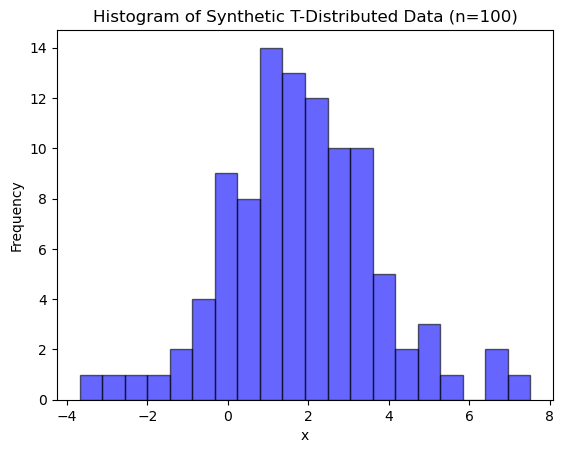

In [45]:
import numpy as np
from numpy.random import normal, standard_t, rand, choice
import math
import matplotlib.pyplot as plt


n = 100
true_mu = 2.0
true_sigma = 1.5
true_nu = 8
x_data = true_mu + true_sigma * standard_t(df=true_nu, size=n)
plt.hist(x_data, bins=20, alpha=0.6, color='blue', edgecolor='k')
plt.title("Histogram of Synthetic T-Distributed Data (n=100)")
plt.xlabel("x")
plt.ylabel("Frequency")
plt.show()


### Log-Posterior Functions

We'll define:
- `log_t_likelihood(mu, sig2, nu, data)`
- `log_prior_mu(mu)`
- `log_prior_sig2(sig2)`
- `log_prior_nu(nu)`

Then combine them into `log_posterior(...)`.  

**Important**: We'll do everything on the **log scale** to avoid numerical underflow, especially for large \(n\).

In [46]:
def log_t_likelihood(mu, sigma, nu, data):
    """
    Log-likelihood for a location-scale Student-t distribution:
    p(x_i | mu, sigma, nu) = Gamma((nu+1)/2) / [Gamma(nu/2)*sqrt(pi*nu*(sigma^2))] *
                             (1 + (1/nu)*((x_i - mu)^2 / (sigma^2)))^(-(nu+1)/2)
    """
    # Invalid region
    if sigma <= 0 or nu < 1 or nu > 100:
        return -np.inf
    
    # Precompute constants that don't depend on x_i
    c = (math.lgamma((nu+1)/2)
         - math.lgamma(nu/2)
         - 0.5 * math.log(math.pi * nu * (sigma**2)))
    
    ll_sum = 0.0
    for x in data:
        z = (x - mu)**2 / (sigma**2)
        ll_sum += c - ((nu+1)/2) * math.log(1 + z/nu)
    return ll_sum

def log_prior_mu(mu, mu0=0.0, tau0=0.01):
    """
    mu ~ Normal(mu0, variance=1/tau0).
    By default, mu0=0, tau0=0.01 => stdev=10
    """
    var = 1/tau0
    return -0.5*math.log(2*math.pi*var) - 0.5*((mu - mu0)**2/var)

def log_prior_sigma(sigma, sigma0=5.0):
    if sigma <= 0:
        return -np.inf
    return - (sigma**2) / (2 * (sigma0**2))

def log_prior_nu(nu):
    """
    discrete uniform on {1,...,100}.
    """
    if (nu < 1) or (nu > 100):
        return -np.inf
    # log(1/100) = -ln(100)
    return -math.log(100.0)

def log_posterior(mu, sigma, nu, data):
    return (log_t_likelihood(mu, sigma, nu, data)
            + log_prior_mu(mu)
            + log_prior_sigma(sigma)
            + log_prior_nu(nu))

### Metropolis-within-Gibbs Sampler

We do 3 updates per iteration:
1. **Update mu** (random-walk proposal)
2. **Update sigma^2** (random-walk on log scale for positivity)
3. **Update nu** (discrete proposal in {1..100})

We'll store the chains for analysis.

In [53]:
def metropolis_within_gibbs(data, n_iter=10000, proposal_sd=0.5, init_vals=(0., 1., 10)):
    mu_chain = np.zeros(n_iter)
    sigma_chain = np.zeros(n_iter)
    nu_chain = np.zeros(n_iter)
    
    mu_current, sigma_current, nu_current = init_vals
    log_post_current = log_posterior(mu_current, sigma_current, nu_current, data)
    
    accept_count = 0
    for t in range(n_iter):
        # 1) Update mu
        mu_prop = normal(mu_current, proposal_sd)  # tune as needed
        log_post_prop = log_posterior(mu_prop, sigma_current, nu_current, data)
        log_accept = log_post_prop - log_post_current
        if np.log(rand()) < log_accept:
            mu_current = mu_prop
            log_post_current = log_post_prop
            accept_count += 1
        
        # 2) Update sig2 on log scale
        log_sigma_current = math.log(sigma_current)
        log_sigma_prop = normal(log_sigma_current, proposal_sd)
        sigma_prop = math.exp(log_sigma_prop)
        
        log_post_prop = log_posterior(mu_current, sigma_prop, nu_current, data)
        log_accept = log_post_prop - log_post_current
        if math.log(np.random.rand()) < log_accept:
            sigma_current = sigma_prop
            log_post_current = log_post_prop
            accept_count += 1
        
        # (3) Update nu (discrete step +/-1)
        step = choice([-1, 1])
        nu_prop = nu_current + step
        nu_prop = max(1, min(100, nu_prop))
        
        log_post_prop = log_posterior(mu_current, sigma_current, nu_prop, data)
        log_accept = log_post_prop - log_post_current
        if math.log(np.random.rand()) < log_accept:
            nu_current = nu_prop
            log_post_current = log_post_prop
            accept_count += 1
        
        mu_chain[t] = mu_current
        sigma_chain[t] = sigma_current
        nu_chain[t] = nu_current
    
    accept_rate = accept_count / (3.0 * n_iter)
    return mu_chain, sigma_chain, nu_chain, accept_rate

# Run the sampler
mu_chain, sigma_chain, nu_chain, acc_rate = metropolis_within_gibbs(x_data)

print(f"Overall acceptance rate (across 3 steps) = {acc_rate:.2f}")

Overall acceptance rate (across 3 steps) = 0.53


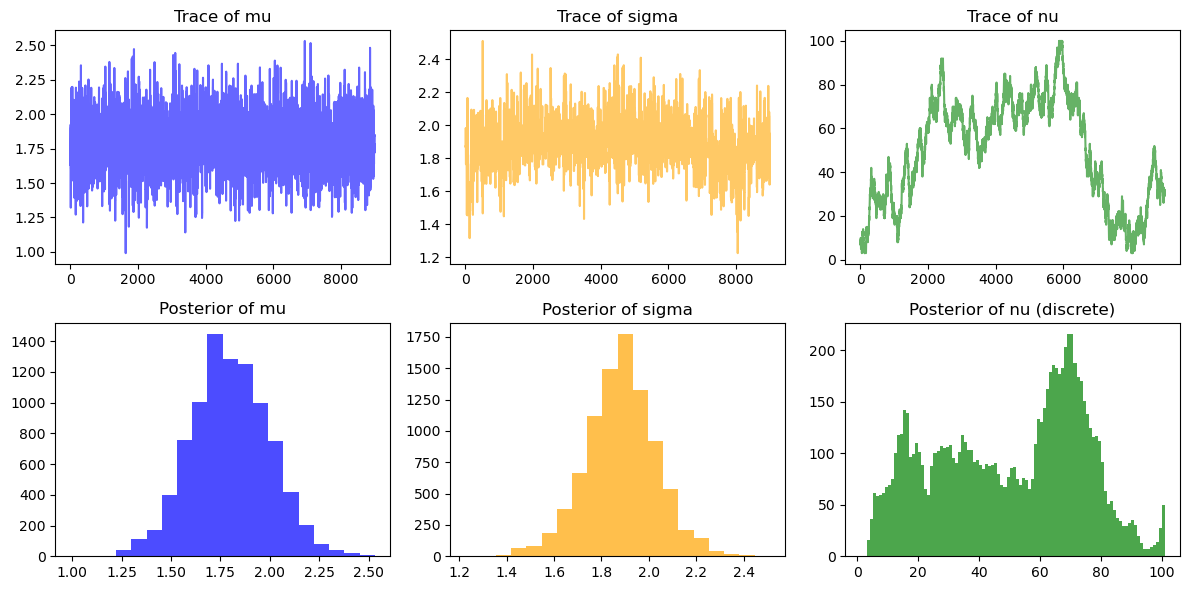

In [61]:
burn_in = 1000
mu_post = mu_chain[burn_in:]
sigma_post = sigma_chain[burn_in:]
nu_post = nu_chain[burn_in:]

fig, axs = plt.subplots(2, 3, figsize=(12,6))

# Trace
axs[0,0].plot(mu_post, color='blue', alpha=0.6)
axs[0,0].set_title("Trace of mu")

axs[0,1].plot(sigma_post, color='orange', alpha=0.6)
axs[0,1].set_title("Trace of sigma")

axs[0,2].plot(nu_post, color='green', alpha=0.6)
axs[0,2].set_title("Trace of nu")

# Hist
axs[1,0].hist(mu_post, bins=20, color='blue', alpha=0.7)
axs[1,0].set_title("Posterior of mu")

axs[1,1].hist(sigma_post, bins=20, color='orange', alpha=0.7)
axs[1,1].set_title("Posterior of sigma")

axs[1,2].hist(nu_post, bins=range(1,102), color='green', alpha=0.7)
axs[1,2].set_title("Posterior of nu (discrete)")

plt.tight_layout()
plt.show()

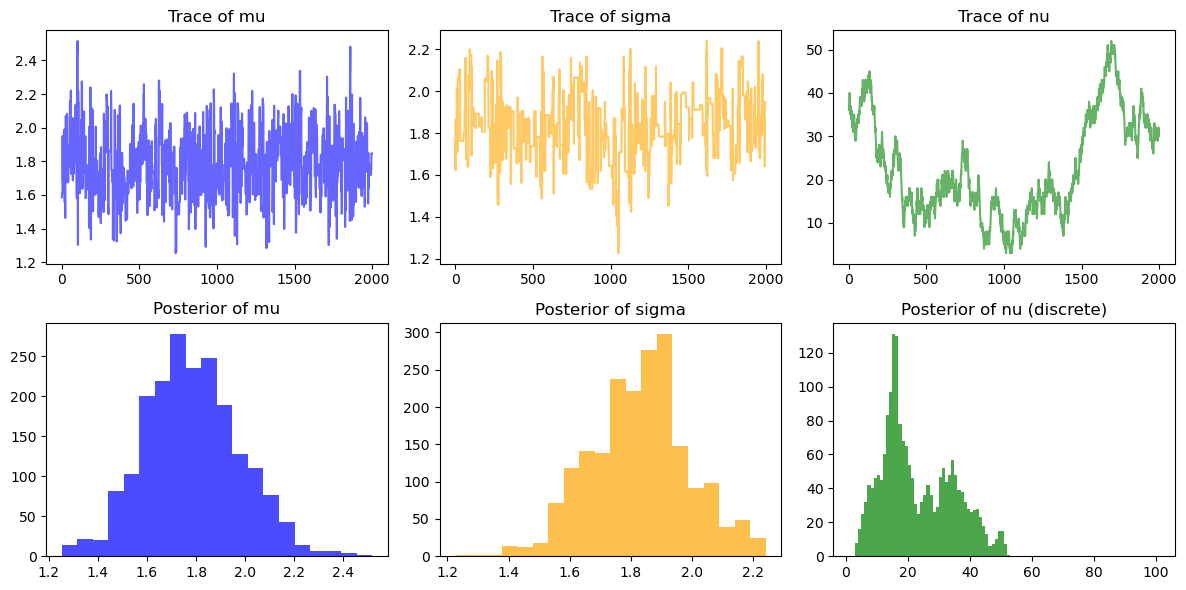

In [60]:
burn_in = 8000
mu_post = mu_chain[burn_in:]
sigma_post = sigma_chain[burn_in:]
nu_post = nu_chain[burn_in:]

fig, axs = plt.subplots(2, 3, figsize=(12,6))

# Trace
axs[0,0].plot(mu_post, color='blue', alpha=0.6)
axs[0,0].set_title("Trace of mu")

axs[0,1].plot(sigma_post, color='orange', alpha=0.6)
axs[0,1].set_title("Trace of sigma")

axs[0,2].plot(nu_post, color='green', alpha=0.6)
axs[0,2].set_title("Trace of nu")

# Hist
axs[1,0].hist(mu_post, bins=20, color='blue', alpha=0.7)
axs[1,0].set_title("Posterior of mu")

axs[1,1].hist(sigma_post, bins=20, color='orange', alpha=0.7)
axs[1,1].set_title("Posterior of sigma")

axs[1,2].hist(nu_post, bins=range(1,102), color='green', alpha=0.7)
axs[1,2].set_title("Posterior of nu (discrete)")

plt.tight_layout()
plt.show()

**Comment**: 
- We see how $\mu$ and $\sigma^2$ vary around the true values $\mu=2$, $\sigma^2=2.25$.
- $\nu$ is trying to cluster around 8 but is struggling. Prior is probably too broad, and samples too low. However, increasing iterations and burn in period shows that eventually it does start to center around 8.

# Q2

Now we want to see how different sample sizes affect the posterior for $\nu$.

### Steps
1. We'll generate data from a t-dist with some true $\nu$.
2. We'll build a **PyMC** model with a discrete uniform prior on $\nu$ in ${1..100}$.
3. We'll compare posterior inferences on $\nu$ for different sample sizes $\nu$.


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [nu]
>NUTS: [mu, sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_500 draw iterations (2_000 + 3_000 draws total) took 0 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Sample size n=20 complete.


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [nu]
>NUTS: [mu, sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_500 draw iterations (2_000 + 3_000 draws total) took 0 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Sample size n=40 complete.


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [nu]
>NUTS: [mu, sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_500 draw iterations (2_000 + 3_000 draws total) took 0 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sample size n=100 complete.


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [nu]
>NUTS: [mu, sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_500 draw iterations (2_000 + 3_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sample size n=250 complete.


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [nu]
>NUTS: [mu, sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_500 draw iterations (2_000 + 3_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sample size n=500 complete.
Summary for n=20:
     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  53.12  26.91     5.0     94.0        1.1     0.78     601.7    595.53   

    r_hat  
nu   1.01  


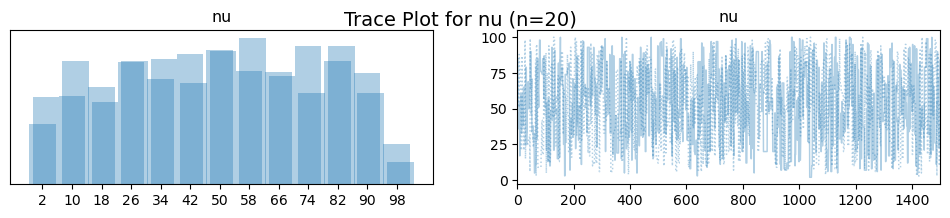

Summary for n=40:
     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  49.99  27.85     4.0     93.0       1.24     0.88     503.6    576.37   

    r_hat  
nu    1.0  


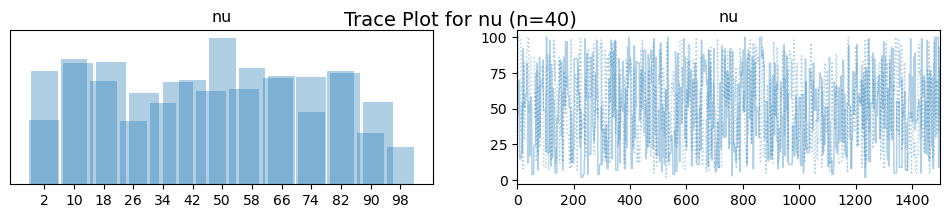

Summary for n=100:
     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  22.62  25.51     2.0     81.0        2.8     1.99     66.51    163.76   

    r_hat  
nu   1.02  


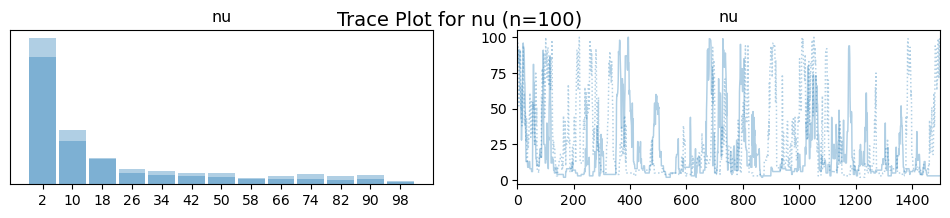

Summary for n=250:
     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  22.13  22.54     3.0     71.0       2.33     1.65     87.83     99.37   

    r_hat  
nu   1.03  


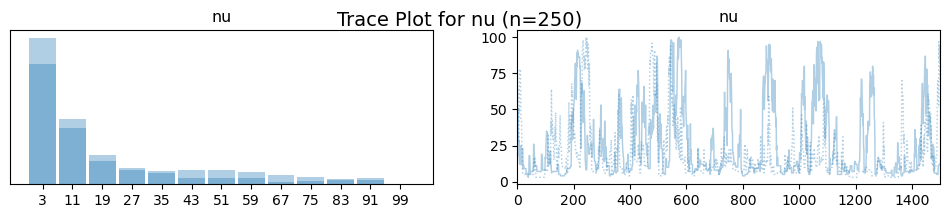

Summary for n=500:
    mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
nu  7.62  3.58     4.0     14.0       0.27     0.19    170.18    230.34   1.02


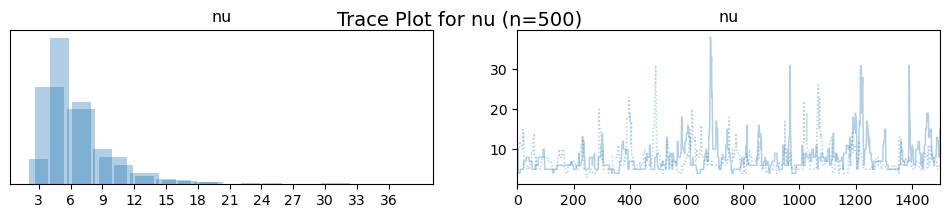

In [29]:
import pymc as pm
import arviz as az

def generate_t_data(n, mu, sigma, nu, seed=42):
    rng = np.random.default_rng(seed)
    return mu + sigma * rng.standard_t(df=nu, size=n)

sample_sizes = [20, 40, 100, 250, 500]
true_mu, true_sigma, true_nu = 2.0, 1.5, 8
model_traces = {}

for n in sample_sizes:
    # Generate synthetic data for current sample size
    data = generate_t_data(n, true_mu, true_sigma, true_nu)
    
    with pm.Model() as model:
        # Discrete Uniform prior on nu: values 1,...,100.
        nu = pm.DiscreteUniform("nu", lower=1, upper=100)
        
        # Normal prior for mu (mean 0, sd 10)
        mu = pm.Normal("mu", mu=0, sigma=10)
        
        # HalfNormal prior for sigma (scale=5)
        sigma = pm.HalfNormal("sigma", sigma=5)

        obs = pm.StudentT("obs", nu=nu, mu=mu, sigma=sigma, observed=data)
        
        trace = pm.sample(draws=1500, tune=1000, chains=2, progressbar=True)
    
    # Store the trace for later analysis.
    model_traces[n] = trace
    print(f"Sample size n={n} complete.")

# For visualization, create ArviZ InferenceData objects and plot the trace for nu.
for n in sample_sizes:
    trace = model_traces[n]
    print(f"Summary for n={n}:")
    print(az.summary(trace, var_names=["nu"], round_to=2))
    az.plot_trace(trace, var_names=["nu"])
    plt.suptitle(f"Trace Plot for nu (n={n})", fontsize=14)
    plt.show()

**Comment**:
- For smaller $n$, the posterior for $\nu$ is quite spread.
- As $n$ grows (100, 250, 500), we see the posterior concentrating near the true $\nu=8$.

# Q3: Posterior Predictive Analogy

We have the integral:

$$
\int p(y_i|\tau_i)\, p(\tau_i)\, d\tau_i
= \int \sqrt{\tfrac{\tau_i}{2\pi}}\, e^{-\tfrac{1}{2}\tau_i y_i^2}
  \;\times\;
  \Bigl(\tfrac{\nu/2}{\Gamma(\nu/2)}\Bigr)\,\tau_i^{\tfrac{\nu}{2}-1}\, e^{-\tfrac{\nu}{2}\tau_i}
  \; d\tau_i.
$$

### 1: Identify the Resulting Distribution

- $p(\tau_i)$ is Gamma $\bigl(\alpha=\nu/2,\;\beta=\nu/2\bigr)$.
- $p(y_i \mid \tau_i)$ is Normal $\bigl(0,\,1/\tau_i\bigr)$.

When you **integrate out** $\tau_i$, you end up with a **Student-t** distribution on $y_i$ with $\nu$ degrees of freedom. This is exactly how a Normal–Gamma conjugate prior leads to a t-marginal.

### 2: Why is This Like a Posterior Predictive?

- In Bayesian inference, the **posterior predictive** for a new observation $y_{\text{new}}$ is
  $$
    \int p(y_{\text{new}} \mid \theta)\, p(\theta \mid \text{data})\, d\theta.
  $$
- Here, we’re integrating out $\tau_i$ from the product $p(y_i|\tau_i)\,p(\tau_i)$. 
- That’s analogous to how we integrate out a parameter in the posterior predictive. 
- **Hence** the result is a Student-t distribution, showing that marginalizing over $\tau_i$ (with a certain Gamma prior) yields heavy-tailed behavior—just like a t.


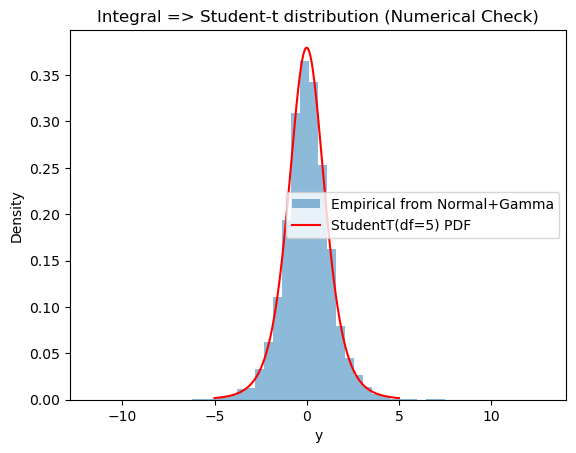

In [10]:
from scipy import stats
nu = 5  
N_sims = 10_000
tau_samples = stats.gamma.rvs(a=nu/2, scale=1/(nu/2), size=N_sims)
y_samples = normal(loc=0, scale=1/np.sqrt(tau_samples), size=N_sims)
xs = np.linspace(-5,5,200)
t_pdf = stats.t.pdf(xs, df=nu)
plt.hist(y_samples, bins=50, density=True, alpha=0.5, label='Empirical from Normal+Gamma')
plt.plot(xs, t_pdf, 'r-', label=f'StudentT(df={nu}) PDF')
plt.title("Integral => Student-t distribution (Numerical Check)")
plt.xlabel("y")
plt.ylabel("Density")
plt.legend()
plt.show()

- The histogram from the Normal+Gamma approach matches the Student-t PDF, confirming that
  $\int p(y|\tau)\,p(\tau)\,d\tau$ yields a t distribution.
- This mirrors how a posterior predictive integral can yield a t-like distribution when you integrate out latent parameters with a Gamma prior.
